In [66]:
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
from IPython.core.display import HTML #library to display HTML content

# get the response in the form of html
wikiurl="https://ru.wikipedia.org/wiki/%D0%9B%D1%8B%D1%81%D1%8B%D0%B9_%E2%80%94_%D0%B2%D0%BE%D0%BB%D0%BE%D1%81%D0%B0%D1%82%D1%8B%D0%B9"
response=requests.get(wikiurl)
if str(response) != '<Response [200]>':
   raise Exception('Can not load web page!')

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')

#find annotation and table
annotation = soup.find_all('p')[0]
table=soup.find('table',{'class':"wikitable"})

#display the content
HTML(str(annotation)+str(table))


In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if F else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torchsummary

In [2]:
torch.cuda.is_available()

True

In [3]:
#import gc  #CLEANING MEMORY

#gc.collect()

#torch.cuda.empty_cache()

In [4]:
train_data_dir = '/kaggle/input/bald-classification-200k-images-celeba/Dataset/Train'
val_data_dir = '/kaggle/input/bald-classification-200k-images-celeba/Dataset/Validation'
test_data_dir = '/kaggle/input/bald-classification-200k-images-celeba/Dataset/Test'

In [5]:
import torchvision.transforms as T

In [6]:
from torch.utils.data import DataLoader, Dataset
class boldnbold(Dataset):
  def __init__(self, folder, size=0):
    halfsize = int(size/2)
    bold = glob(folder+'/Bald/*.jpg')
    nbold = glob(folder+'/NotBald/*.jpg')
    if size != 0:
        self.fpaths = bold[:halfsize] + nbold[:halfsize]
    else:
        self.fpaths = bold + nbold
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-2].startswith('Bald') for fpath in self.fpaths]
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = torch.tensor(im/255).permute(2,0,1)
    im = T.Pad(padding = (40, 0, 0, 0))(im)
    return im.to(device).float(), torch.tensor([target]).float().to(device)

In [7]:
data = boldnbold(train_data_dir, size=7000)


In [8]:
len(data)

7000

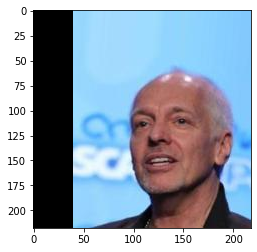

In [9]:
im, label = data[22]
plt.imshow(im.permute(1,2,0).cpu())

In [56]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
    )
def get_model():
    model = nn.Sequential(
    nn.Dropout2d(0.25),
    conv_layer(3, 64, 3),
    nn.Dropout2d(0.25),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [11]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 218, 218))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 216, 216]           1,792
              ReLU-2         [-1, 64, 216, 216]               0
       BatchNorm2d-3         [-1, 64, 216, 216]             128
         MaxPool2d-4         [-1, 64, 108, 108]               0
            Conv2d-5        [-1, 512, 106, 106]         295,424
              ReLU-6        [-1, 512, 106, 106]               0
       BatchNorm2d-7        [-1, 512, 106, 106]           1,024
         MaxPool2d-8          [-1, 512, 53, 53]               0
            Conv2d-9          [-1, 512, 51, 51]       2,359,808
             ReLU-10          [-1, 512, 51, 51]               0
      BatchNorm2d-11          [-1, 512, 51, 51]           1,024
        MaxPool2d-12          [-1, 512, 25, 25]               0
           Conv2d-13          [-1, 512, 23, 23]       2,359,808
             ReLU-14          [-1, 512,

In [45]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    l_regularization = 0
    for param in model.parameters():
          l_regularization += torch.norm(param,2)
    batch_loss = loss_fn(prediction, y) + 0.005*l_regularization
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def evaluate(x, y, model):
    model.eval()
    prediction = model(x)
    TP = torch.eq((prediction > 0.5), y == 1)
    TN = torch.eq((prediction <= 0.5), y == 0)
    FP = torch.eq((prediction > 0.5),  y == 0)
    FN = torch.eq((prediction <= 0.5),  y == 1)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return precision.cpu().numpy().tolist(), recall.cpu().numpy().tolist(), accuracy.cpu().numpy().tolist()

In [13]:
def get_data():     
    train = boldnbold(train_data_dir, size=7000)
    trn_dl = DataLoader(train, batch_size=50, shuffle=True, drop_last = True)
    val = boldnbold(test_data_dir, size=700)
    val_dl = DataLoader(val, batch_size=50, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [14]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [57]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [64]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [17]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from time import sleep
from tqdm.notebook import tqdm
from torch import optim


In [58]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epochs = []

Adjusting learning rate of group 0 to 1.0000e-03.
epoch:  0


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0000e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


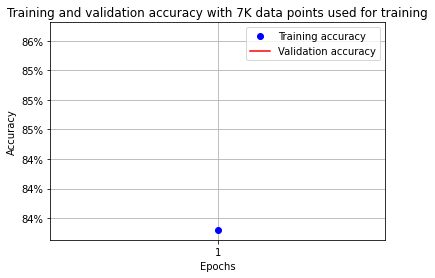

epoch:  1


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1000e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

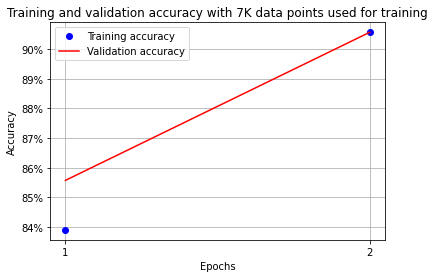

epoch:  2


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2900e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

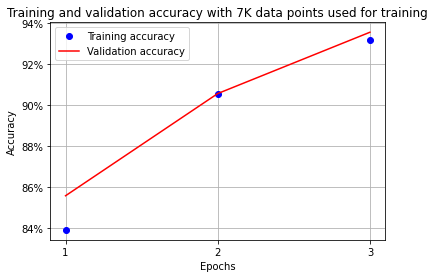

epoch:  3


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5610e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

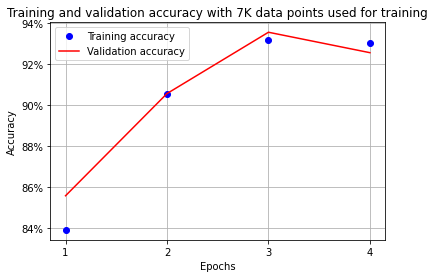

epoch:  4


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9049e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

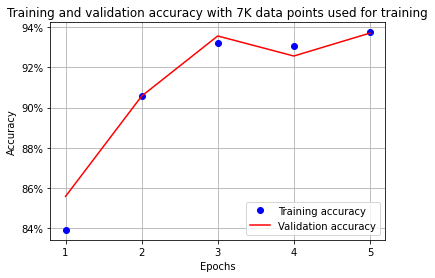

epoch:  5


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3144e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

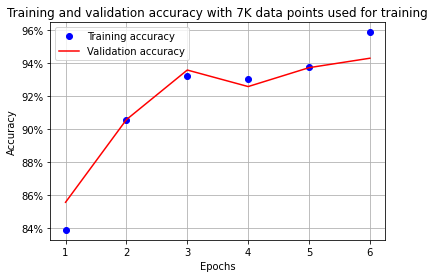

epoch:  6


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7830e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

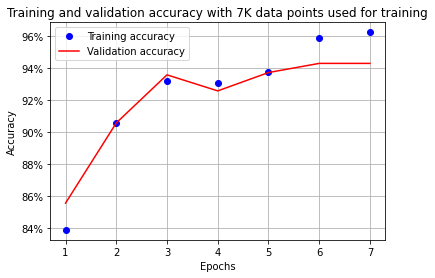

epoch:  7


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3047e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

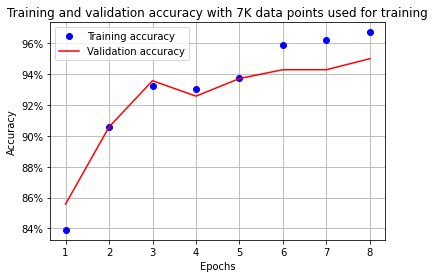

epoch:  8


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8742e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

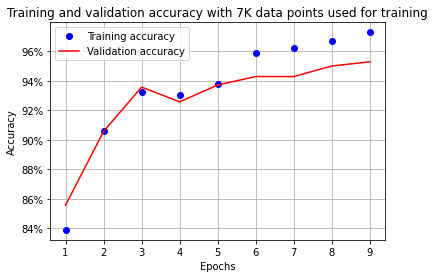

epoch:  9


  0%|          | 0/140 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4868e-04.


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

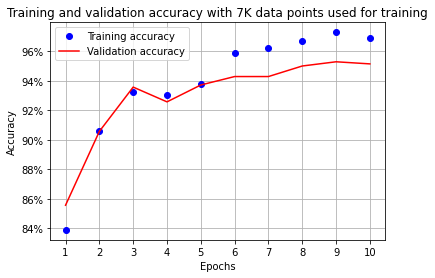

In [59]:
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

for epoch in range(10):
    
    print('epoch: ', epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    tbar = tqdm(iter(trn_dl))
    for batch in tbar:
        tbar.set_description("Training")
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    scheduler.step()

    tvbar = tqdm(iter(trn_dl))
    for batch in tvbar:
        tvbar.set_description("Calculating train accuracy")
        x, y = batch
        _, __, is_correct = evaluate(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    vbar = tqdm(iter(val_dl))
    for batch in vbar:
        vbar.set_description("Calculating validation accuracy")
        x, y = batch
        _, __, val_is_correct = evaluate(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    epochs.append(epoch + 1)
    %matplotlib inline
    plt.clf()
    plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Training and validation accuracy with 7K data points used for training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.ylim(0.8,1)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()
    ##TODO plot

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 7K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
print(train_accuracies)

In [39]:
def get_test_data(): 
    test = boldnbold(test_data_dir)
    tst_dl = DataLoader(test, batch_size=100, shuffle=True, drop_last = True)
    return tst_dl

In [40]:
tst_dl = get_test_data()


In [62]:
x1, y1 = next(iter(tst_dl))
print(x1.size(), y1.size())

torch.Size([100, 3, 218, 218]) torch.Size([100, 1])


In [65]:
pred = model(x1)
for i, im in enumerate(x1):
    if i >15:
        break
    plt.figure()
    plt.imshow(im.permute(1,2,0).cpu())
    plt.title(f'model: {float(pred[i]):.2f}, truth: {float(y1[i]):.2f}')
    
    


RuntimeError: CUDA out of memory. Tried to allocate 1.11 GiB (GPU 0; 15.90 GiB total capacity; 13.98 GiB already allocated; 509.75 MiB free; 14.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [60]:
test_losses, test_accuracies, test_recalls, test_precisions = [], [], [], []
tstbar = tqdm(iter(tst_dl))
for batch in tstbar:
    tstbar.set_description("Testing")
    x, y = batch
    precision, recall, accuracy = evaluate(x1, y1, model)
    test_recalls.extend(recall)
    test_precisions.extend(precision)
    test_accuracies.extend(accuracy)

print(np.mean(test_recalls), np.mean(test_precisions), np.mean(test_accuracies))

  0%|          | 0/200 [00:00<?, ?it/s]

0.96 0.96 0.96
